## Data reading and Data Insights

**Creating literary works participant: feiing6c, 32 days participation**
 
*Dataset:*  Creating literary works (A) (using your imagination to write poems, stories, plays, and various creative writings) vs Not creating literary works (B) (continuing your daily routine normally)

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.scan import scan

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
path = "C://Users//USER//Desktop//StudyU_Results//"
df_intervention = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-_creating_literary_works_-_feiing6c_2025-05-27 15_57_14.335//interventions.csv")
#print(df_intervention.head())
df_mea = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-_creating_literary_works_-_feiing6c_2025-05-27 15_57_14.335//measurements.csv")
#print(df_mea.head())

## Data Analysis and Preprocessing

- Pre-analysis: feiing6c
    - Number of Participant
    - Participation of the study
    - Missing Values
    - Remove Participants Who Joined Outside the Study
    - Data Preperation

#### Number of Participant

In [3]:
column_name = 'participant_id' 

unique_count = df_intervention[column_name].nunique()

if unique_count == 1:
    only_value = df_intervention[column_name].iloc[0]
    print(f"The column '{column_name}' has only one unique value: {only_value!r}")
else:
    print(f"The column '{column_name}' has {unique_count} unique values.")
    print("Unique values are:", df_intervention[column_name].unique())

The column 'participant_id' has only one unique value: 'a0bf0598-50cf-4b1b-bad0-5c402be7b5f5'


#### Participation of the study

In [4]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'], utc=True)

participation_days = (
    df_mea
    .groupby('participant_id')['measurement_time']
    .apply(lambda x: x.dt.date.nunique())
    .reset_index(name='participation_days')
)

print(participation_days)

                         participant_id  participation_days
0  a0bf0598-50cf-4b1b-bad0-5c402be7b5f5                  30


During the 32-day study period, there were 2 days without any participation.

#### Missing Values

In [5]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in ['Outcome', 'Mediators']:
        sub = df_part[df_part['measurement_name'] == name].copy()
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=32, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),            
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant a0bf0598-50cf-4b1b-bad0-5c402be7b5f5 ---

  Outcome:
    Start date:           2025-04-21
    End of expected 16d:  2025-05-22
    Expected days count:  32
    Completed days count: 30
    Missed days count:    2
    Missed dates:
       2025-04-30
       2025-05-17

  Mediators:
    Start date:           2025-04-21
    End of expected 16d:  2025-05-22
    Expected days count:  32
    Completed days count: 30
    Missed days count:    2
    Missed dates:
       2025-04-30
       2025-05-17


#### Remove Participants Who Joined Outside the Study

In [6]:
#df_mea = df_mea[df_mea['participant_id'] != 'ae098342-296b-4dca-83c0-76b2f3507008']
#df_mea.shape[0]

#### Data Preperation

In [7]:
df_mea_all= df_mea[[
     'measurement_time',
     'measurement_name',
     'participant_id',
     'current_day_of_study',
     'current_intervention_name',
     'survey1_question1_response',
     'survey1_question2_response',
     'survey1_question3_response',
     'survey1_question4_response',
     'survey2_question1_response',
     'survey2_question2_response']]
df_mea_all.head(1)
    

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
0,2025-05-22 18:05:33.657127+00:00,Mediators,a0bf0598-50cf-4b1b-bad0-5c402be7b5f5,31,Not Creating Literary Works!,NaN,NaN,NaN,NaN,2.0,2.0


In [8]:
df_mea_m = df_mea_all[df_mea_all['measurement_name'] == 'Mediators']
df_mea_o = df_mea_all[df_mea_all['measurement_name'] == 'Outcome']

In [9]:
df_mea_o = df_mea_o.sort_values(by=['participant_id', 'current_day_of_study'])
df_mea_m = df_mea_m.sort_values(by=['participant_id', 'current_day_of_study'])

In [10]:
df_mea_o.tail()

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
9,2025-05-18 18:04:35.153803+00:00,Outcome,a0bf0598-50cf-4b1b-bad0-5c402be7b5f5,27,Creating Literary Works!,3.0,2.0,2.0,1.0,NaN,NaN
7,2025-05-19 18:01:53.004878+00:00,Outcome,a0bf0598-50cf-4b1b-bad0-5c402be7b5f5,28,Not Creating Literary Works!,3.0,2.0,1.0,2.0,NaN,NaN
5,2025-05-20 18:04:36.074742+00:00,Outcome,a0bf0598-50cf-4b1b-bad0-5c402be7b5f5,29,Not Creating Literary Works!,2.0,3.0,1.0,3.0,NaN,NaN
3,2025-05-21 19:04:29.915890+00:00,Outcome,a0bf0598-50cf-4b1b-bad0-5c402be7b5f5,30,Not Creating Literary Works!,2.0,2.0,1.0,2.0,NaN,NaN
1,2025-05-22 18:05:30.356341+00:00,Outcome,a0bf0598-50cf-4b1b-bad0-5c402be7b5f5,31,Not Creating Literary Works!,2.0,2.0,1.0,2.0,NaN,NaN


## Exploratory Data Analysis - Outcome

- EDA Steps  
  - Data shape  
  - Data types of columns  
  - Missing values  
  - Summary statistics  
  - Data Visualization and Distributions  
    - Plot histograms and box plots  
    - Line plot  
    - Scatter plot  
    - Correlations (Pearson, Kendall, Spearman)  
  - Correlation   

#### Data Shape

In [11]:
print("Outcome Data Shape")
print("Rows:", df_mea_o.shape[0])
print("Columns:", df_mea_o.shape[1])

Outcome Data Shape
Rows: 30
Columns: 11


#### Data Types of columns

In [12]:
print("Outcome Data Types of Columns")
data_types = df_mea_o.dtypes
data_types_df = pd.DataFrame(data_types, columns=["Data Type"])
print(data_types_df)

Outcome Data Types of Columns
                                      Data Type
measurement_time            datetime64[ns, UTC]
measurement_name                         object
participant_id                           object
current_day_of_study                      int64
current_intervention_name                object
survey1_question1_response              float64
survey1_question2_response              float64
survey1_question3_response              float64
survey1_question4_response              float64
survey2_question1_response              float64
survey2_question2_response              float64


#### Missing Value Analysis

In [13]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

df_mea.columns = df_mea.columns.str.strip()
df_mea['measurement_name'] = df_mea['measurement_name'].str.strip()

measurement_names = [
    'Outcome',
    'Mediators',
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response',
    'survey2_question1_response',
    'survey2_question2_response'
]

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in measurement_names:
        if name in ['Outcome', 'Mediators']:
            sub = df_part[df_part['measurement_name'] == name].copy()
        else:
            if name not in df_part.columns:
                sub = pd.DataFrame()
            else:
                sub = df_part[df_part[name].notna()].copy()
        
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=32, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),       
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant a0bf0598-50cf-4b1b-bad0-5c402be7b5f5 ---

  Outcome:
    Start date:           2025-04-21
    End of expected 16d:  2025-05-22
    Expected days count:  32
    Completed days count: 30
    Missed days count:    2
    Missed dates:
       2025-04-30
       2025-05-17

  Mediators:
    Start date:           2025-04-21
    End of expected 16d:  2025-05-22
    Expected days count:  32
    Completed days count: 30
    Missed days count:    2
    Missed dates:
       2025-04-30
       2025-05-17

  survey1_question1_response:
    Start date:           2025-04-21
    End of expected 16d:  2025-05-22
    Expected days count:  32
    Completed days count: 30
    Missed days count:    2
    Missed dates:
       2025-04-30
       2025-05-17

  survey1_question2_response:
    Start date:           2025-04-21
    End of expected 16d:  2025-05-22
    Expected days count:  32
    Completed days count: 30
    Missed days count:    2
    Missed dates:
       2025-04-30
       2025-05-1

#### Missing Values for Confirmations between 08.00 - 21.00

In [14]:
df_intervention['intervention_task_time'] = pd.to_datetime(
    df_intervention['intervention_task_time'],
    errors='coerce'
)

df_intervention['date'] = df_intervention['intervention_task_time'].dt.date

start_date = df_intervention['date'].min()
full_range = pd.date_range(start=start_date, periods=32, freq='D').date

full_df = pd.DataFrame({'date': full_range})
merged = full_df.merge(
    df_intervention[['date', 'intervention_task_name']],
    on='date',
    how='left'
)

missing_days = merged[merged['intervention_task_name'].isna()]

if missing_days.empty:
    print("All 32 days have participation confirmations; no missing days found.")
else:
    print("Missing participation days and their corresponding task names:")
    print(missing_days)

All 32 days have participation confirmations; no missing days found.


#### Summary Statistics

In [15]:
print("Sleep Data Summary Statistics")
summary_stats = df_mea_o.describe()
print(summary_stats)

Sleep Data Summary Statistics
       current_day_of_study  survey1_question1_response  \
count             30.000000                   30.000000   
mean              15.366667                    3.800000   
std                9.422948                    1.689726   
min                0.000000                    2.000000   
25%                7.250000                    3.000000   
50%               15.500000                    3.000000   
75%               22.750000                    4.000000   
max               31.000000                    8.000000   

       survey1_question2_response  survey1_question3_response  \
count                   30.000000                   30.000000   
mean                     3.466667                    2.533333   
std                      1.655364                    2.029665   
min                      2.000000                    1.000000   
25%                      2.000000                    1.000000   
50%                      3.000000               

In [16]:
df_mea_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 60 to 1
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   measurement_time            30 non-null     datetime64[ns, UTC]
 1   measurement_name            30 non-null     object             
 2   participant_id              30 non-null     object             
 3   current_day_of_study        30 non-null     int64              
 4   current_intervention_name   30 non-null     object             
 5   survey1_question1_response  30 non-null     float64            
 6   survey1_question2_response  30 non-null     float64            
 7   survey1_question3_response  30 non-null     float64            
 8   survey1_question4_response  30 non-null     float64            
 9   survey2_question1_response  0 non-null      float64            
 10  survey2_question2_response  0 non-null      float64            
dtype

#### Data Visualization and Distributions

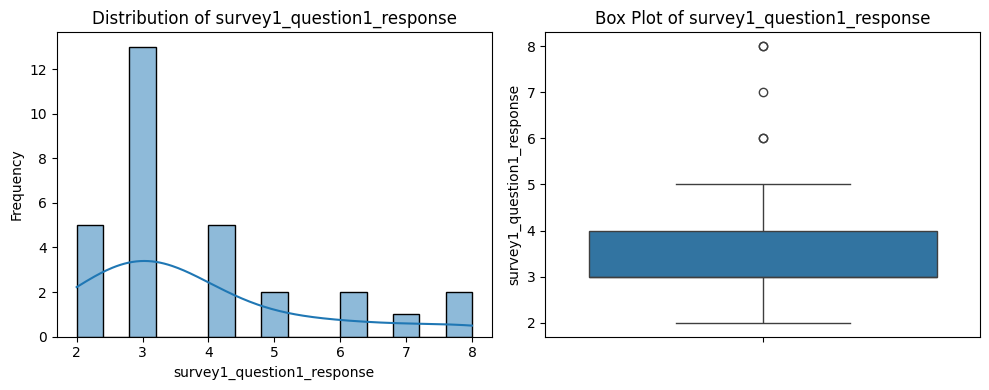

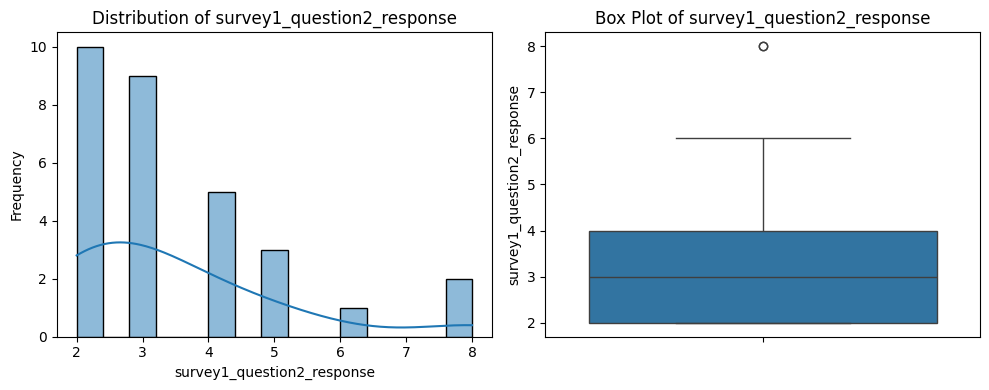

In [17]:
columns = [
    'survey1_question1_response',
    'survey1_question2_response']
for column in columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_mea_o[column].dropna(), bins=15, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_mea_o[column].dropna())
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#### Line Plot

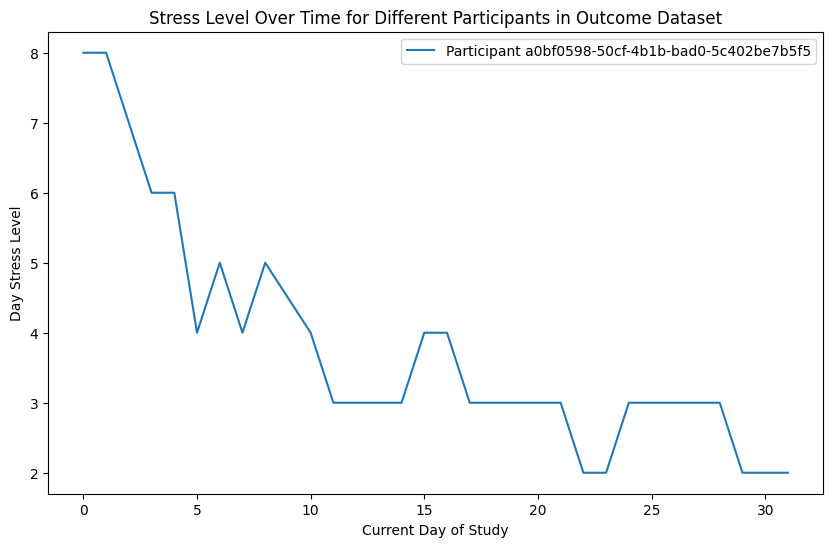

In [18]:
grouped_data = df_mea_o.groupby("participant_id")

plt.figure(figsize=(10, 6)) 

for participant_id, group in grouped_data:
    plt.plot(group['current_day_of_study'], group['survey1_question1_response'], label=f'Participant {participant_id}')

plt.xlabel('Current Day of Study')
plt.ylabel('Day Stress Level')
plt.title('Stress Level Over Time for Different Participants in Outcome Dataset')


plt.legend()
plt.show()


#### Scatterplot

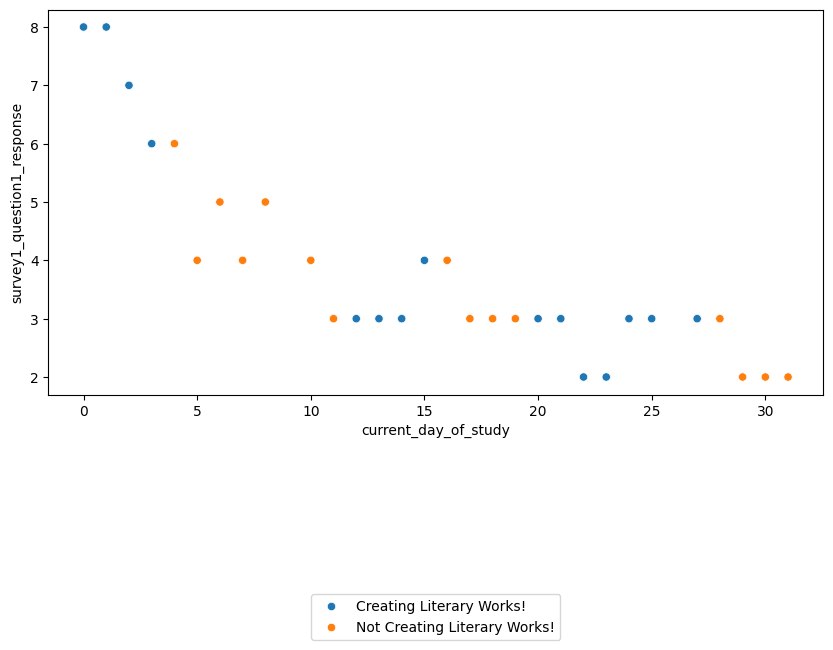

In [19]:
x = 'current_day_of_study'
y = 'survey1_question1_response'

participant_list= list(df_mea_o.participant_id.unique())
fig, axs = plt.subplots(len(participant_list), figsize=(10, 5 * len(participant_list)))

if len(participant_list) == 1:
    axs = [axs]

for i in range(len(participant_list)):
    legend = True if i == len(participant_list)-1 else False
    sns.scatterplot(
        data=df_mea_o[df_mea_o["participant_id"] == participant_list[i]],
        x=x, y=y, hue='current_intervention_name',
        ax=axs[i], legend=legend
    )

axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5))


#### Correlations

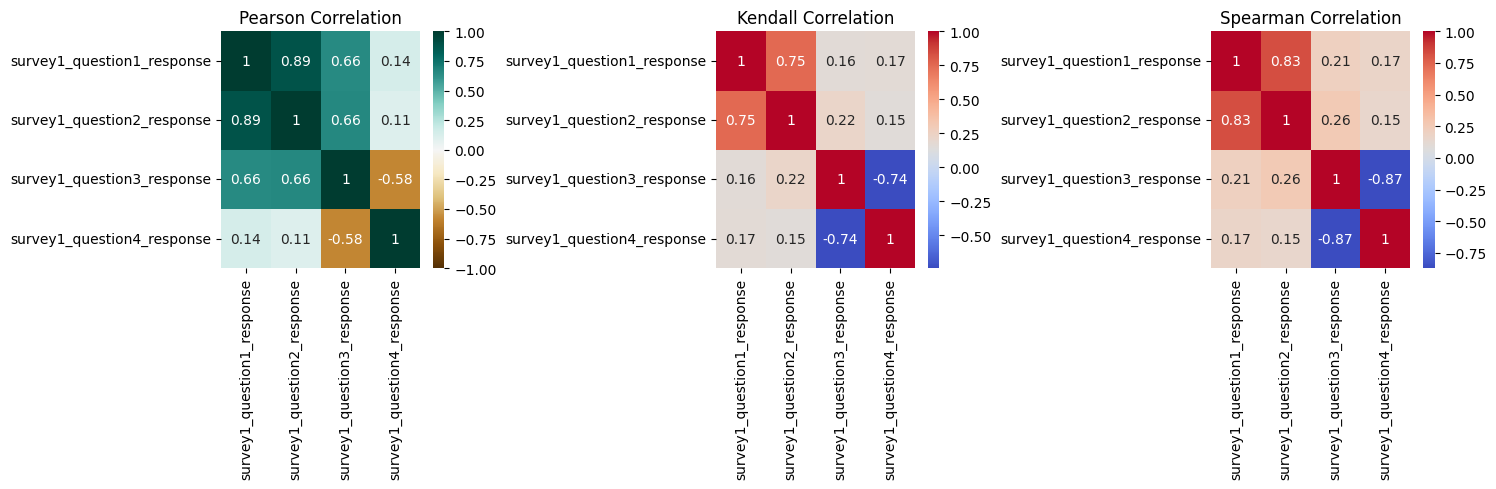

In [20]:
columns_to_include = [
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response']

correlation_pearson = df_mea_all[columns_to_include].corr(method='pearson')
correlation_kendall = df_mea_all[columns_to_include].corr(method='kendall')
correlation_spearman = df_mea_all[columns_to_include].corr(method='spearman')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(correlation_pearson, vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0], center=0)
axes[0].set_title('Pearson Correlation')

sns.heatmap(correlation_kendall, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')

sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

## Baseline Study: Creating Literary Works! vs Not Creating Literary Works!

  - Baseline Studies  
    - Examination of Outcomes   
    - Linear Regression  
      - Ordinary Least Squares (OLS) Regression  
      - Linear Regression with Autoregressive Errors 
      - Bayesian linear regression models
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators
        - Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)
        - Bayesian AR(1) Regression with Consecutive‐Day Adjustment
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Mean Imputation Method
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Latent Variable Method

#### Examination of Outcomes: Today Stress Level

In [21]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Creating Literary Works!",
        "Not Creating Literary Works!"
    ])
]

concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Creating Literary Works!",
    'survey1_question1_response'
]
avoid_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not Creating Literary Works!",
    'survey1_question1_response'
]

n_concretizing         = concretizing.count()
n_avoid_concretizing   = avoid_concretizing.count()
std_concretizing       = concretizing.std(ddof=1)
std_avoid_concretizing = avoid_concretizing.std(ddof=1)

print(f"Creating Literary Works!:           n = {n_concretizing}, std = {std_concretizing:.2f}, mean = {concretizing.mean():.2f}")
print(f"Not Creating Literary Works!:       n = {n_avoid_concretizing}, std = {std_avoid_concretizing:.2f}, mean = {avoid_concretizing.mean():.2f}\n")


Creating Literary Works!:           n = 15, std = 2.09, mean = 4.07
Not Creating Literary Works!:       n = 15, std = 1.19, mean = 3.53



#### Examination of Outcomes: Prediction of Tomorrow Stress

In [22]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question2_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Creating Literary Works!",
        "Not Creating Literary Works!"
    ])
]

concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Creating Literary Works!",
    'survey1_question2_response'
]
avoid_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not Creating Literary Works!",
    'survey1_question2_response'
]

n_concretizing         = concretizing.count()
n_avoid_concretizing   = avoid_concretizing.count()
std_concretizing       = concretizing.std(ddof=1)
std_avoid_concretizing = avoid_concretizing.std(ddof=1)

print(f"Creating Literary Works:           n = {n_concretizing}, std = {std_concretizing:.2f}, mean = {concretizing.mean():.2f}")
print(f"Not Creating Literary Works:       n = {n_avoid_concretizing}, std = {std_avoid_concretizing:.2f}, mean = {avoid_concretizing.mean():.2f}\n")


Creating Literary Works:           n = 15, std = 2.09, mean = 3.73
Not Creating Literary Works:       n = 15, std = 1.08, mean = 3.20



#### Examination of Outcomes: Mean Stress-Relief Score for Creating Literary Works (Q3)
The average score for Question 3 (survey1_question3_response), which assesses how much  to concretizing good things alleviated participants’ stress on days they performed.

In [23]:
df_mea.survey1_question3_text[0]

'How much did this method (creative writing) help you feel better about yourself? <b>(1 = Not helpful at all to 10 = Very helpful) <i>(Answer ONLY if you have written creative writing!)</i></b>'

In [24]:
# 'How much did this method (creative writing) help you feel better about yourself? <b>(1 = Not helpful at all to 10 = Very helpful) <i>(Answer ONLY if you have written creative writing!)</i></b>'
mean_q3_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Creating Literary Works!",
    'survey1_question3_response'
].mean()
mean_q3_concretizing.item()


3.933333333333333

**Mean Self-Improvement Score for Creating Literary Works (Q3): 3.93:**
On days when the participant engaged in creative writing, he rated Question 3—“How much did this method (creative writing) help you feel better about yourself?”—an average of 3.9 out of 10, indicating that creative writing provided only a slight boost to his self-perception.

#### Examination of Outcomes: Mean Stress-Management Difficulty Without Creating Literary Works (Q4)
The average score for Question 4 (survey1_question4_response), which measures participants’ difficulty in managing stress on days they did not creative writings.

In [25]:
df_mea.survey1_question4_text[0]

'When you are not practicing the method (without creative writing) today, do you feel a lack or difficulty in managing your stress? <b>(1 = No difficulty to 10 = Significant difficulty) <i>(Answer ONLY if you have NOT written creative writing!)</i></b>'

In [26]:
# 'When you are not practicing the method (without creative writing) today, do you feel a lack or difficulty in managing your stress? <b>(1 = No difficulty to 10 = Significant difficulty) <i>(Answer ONLY if you have NOT written creative writing!)</i></b>'

mean_q4_avoid_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not Creating Literary Works!",
    'survey1_question4_response'
].mean()
mean_q4_avoid_concretizing.item()


3.0

**Mean Stress-Management Difficulty Score Without Creating Literary Works (Q4): 3.0:**
On days when the participant did not practice creative writing, he rated Question 4—“When you are not practicing the method (without creative writing) today, do you feel a lack or difficulty in managing your stress?”—an average of **3.0 out of 10**, indicating that skipping creative writing posed only a minimal challenge in managing stress.

### Estimating treatment effect using Linear Regression with Autoregressive errors

In [27]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin(["Creating Literary Works!", "Not Creating Literary Works!"])
]

df_mea_o = df_mea_o.sort_values('measurement_time')

y = df_mea_o['survey1_question1_response']
df_mea_o['D'] = (df_mea_o['current_intervention_name'] == "Creating Literary Works!").astype(int)
X = sm.add_constant(df_mea_o['D'])

ols_res = sm.OLS(y, X).fit()
dw_ols = durbin_watson(ols_res.resid)

print("OLS Regression Results:")
print(ols_res.summary())
print(f"Durbin–Watson statistic (OLS residuals): {dw_ols:.3f}\n")

OLS Regression Results:
                                OLS Regression Results                                
Dep. Variable:     survey1_question1_response   R-squared:                       0.026
Model:                                    OLS   Adj. R-squared:                 -0.009
Method:                         Least Squares   F-statistic:                    0.7405
Date:                        Thu, 14 Aug 2025   Prob (F-statistic):              0.397
Time:                                08:45:16   Log-Likelihood:                -57.405
No. Observations:                          30   AIC:                             118.8
Df Residuals:                              28   BIC:                             121.6
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [28]:
# GLSAR Regression with AR(1) errors (Feasible GLS) 
glsar = sm.GLSAR(y, X, rho=1)
glsar_res = glsar.iterative_fit(maxiter=10)
dw_glsar = durbin_watson(glsar_res.resid)

print("GLSAR Regression Results (AR(1) error structure):")
print(glsar_res.summary())
print(f"Estimated AR(1) coefficient (rho): {glsar.rho[0]:.3f}")
print(f"Durbin–Watson statistic (GLSAR residuals): {dw_glsar:.3f}")

GLSAR Regression Results (AR(1) error structure):
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.002
Model:                                  GLSAR   Adj. R-squared:                 -0.035
Method:                         Least Squares   F-statistic:                   0.04489
Date:                        Thu, 14 Aug 2025   Prob (F-statistic):              0.834
Time:                                08:45:16   Log-Likelihood:                -28.330
No. Observations:                          29   AIC:                             60.66
Df Residuals:                              27   BIC:                             63.40
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

#### Bayesian AR(1) Model of Daily Stress Response to Creating Literary Works and Mediators

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 68 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.031  0.357    -0.642      0.737      0.012    0.015     875.0   
rho       0.975  0.026     0.935      1.000      0.001    0.002     450.0   
sigma     0.803  0.115     0.592      1.035      0.005    0.004     564.0   

          ess_tail  r_hat  
beta_int     561.0   1.01  
rho          371.0   1.00  
sigma        517.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 5.70%
P(beta_int ≤ –0.5) = 5.70%
P(–0.5 < beta_int < 0) = 41.50%
P(beta_int ≥ 0) = 52.80%


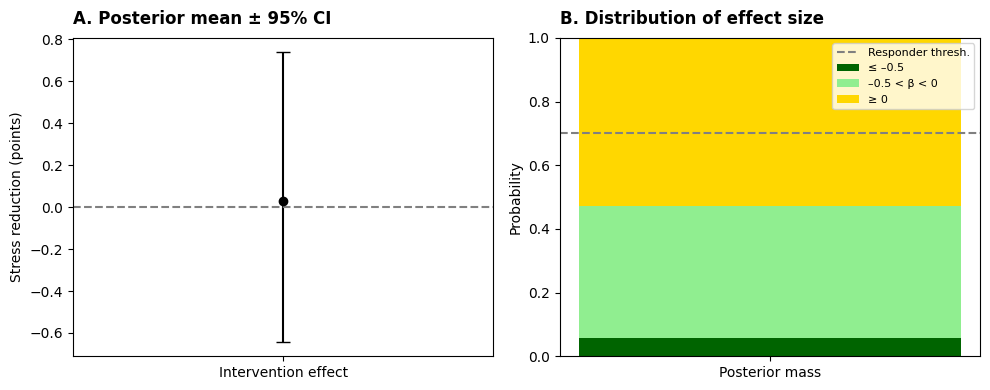

Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 189 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.090  0.303    -0.690      0.479      0.014    0.011     487.0   
rho       0.813  0.197     0.413      0.999      0.012    0.011     237.0   
sigma     0.713  0.103     0.527      0.912      0.005    0.005     476.0   
beta_f1   0.544  0.187     0.190      0.914      0.012    0.008     230.0   

          ess_tail  r_hat  
beta_int     481.0   1.01  
rho          452.0   1.00  
sigma        451.0   1.01  
beta_f1      299.0   1.02  
P(intervention reduces stress by ≥ 0.5 points) = 9.50%
P(beta_int ≤ –0.5) = 9.50%
P(–0.5 < beta_int < 0) = 53.20%
P(beta_int ≥ 0) = 37.30%


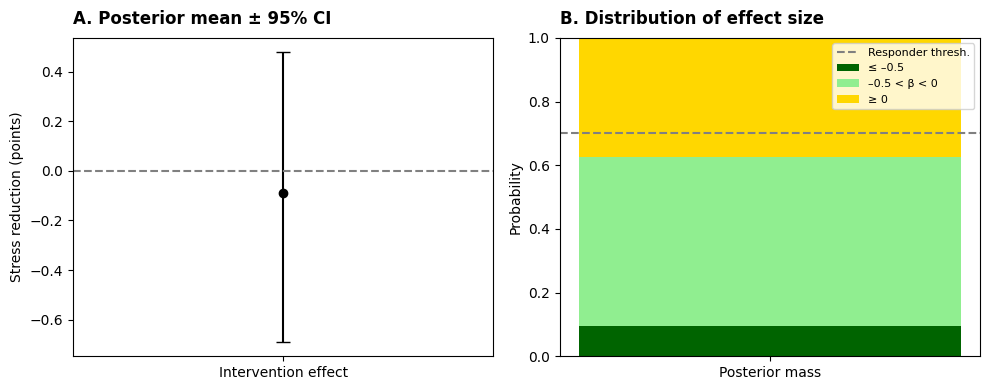

Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 256 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.076  0.348    -0.615      0.727      0.018    0.014     392.0   
rho       0.772  0.259     0.249      1.000      0.029    0.013      83.0   
sigma     0.810  0.121     0.574      1.048      0.006    0.006     338.0   
beta_f2   0.400  0.328    -0.158      0.960      0.038    0.009      81.0   

          ess_tail  r_hat  
beta_int     322.0   1.01  
rho          341.0   1.05  
sigma        191.0   1.01  
beta_f2      276.0   1.04  
P(intervention reduces stress by ≥ 0.5 points) = 4.90%
P(beta_int ≤ –0.5) = 4.90%
P(–0.5 < beta_int < 0) = 37.40%
P(beta_int ≥ 0) = 57.70%


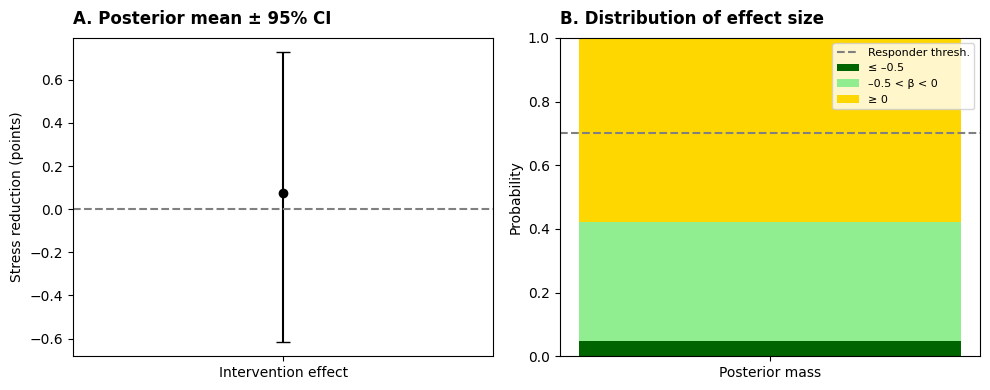

Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 347 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.062  0.311    -0.655      0.526      0.014    0.013     541.0   
rho       0.648  0.292     0.069      0.999      0.026    0.010     120.0   
sigma     0.709  0.095     0.548      0.899      0.005    0.003     304.0   
beta_f1   0.522  0.178     0.195      0.875      0.011    0.007     281.0   
beta_f2   0.160  0.236    -0.255      0.620      0.017    0.007     193.0   

          ess_tail  r_hat  
beta_int     517.0   1.00  
rho          249.0   1.02  
sigma        384.0   1.01  
beta_f1      413.0   1.00  
beta_f2      458.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 8.80%
P(beta_int ≤ –0.5) = 8.80%
P(–0.5 < beta_int < 0) = 47.90%
P(beta_int ≥ 0) = 43.30%


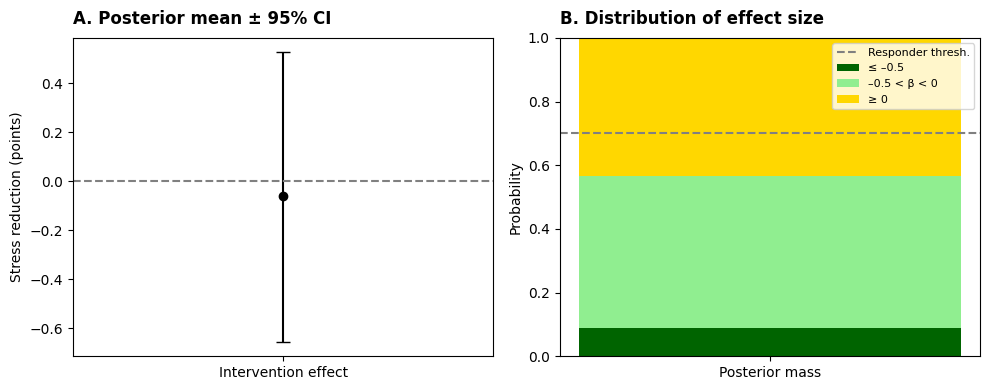

In [29]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Creating Literary Works!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

Model: Only intervention


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 103 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.115  0.369    -0.565      0.894      0.014    0.014     700.0   
rho       0.966  0.038     0.899      1.000      0.002    0.004     415.0   
sigma     0.822  0.131     0.595      1.068      0.005    0.006     626.0   

          ess_tail  r_hat  
beta_int     464.0    1.0  
rho          355.0    1.0  
sigma        533.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 4.60%
P(beta_int ≤ –0.5) = 4.60%
P(–0.5 < beta_int < 0) = 32.70%
P(beta_int ≥ 0) = 62.70%


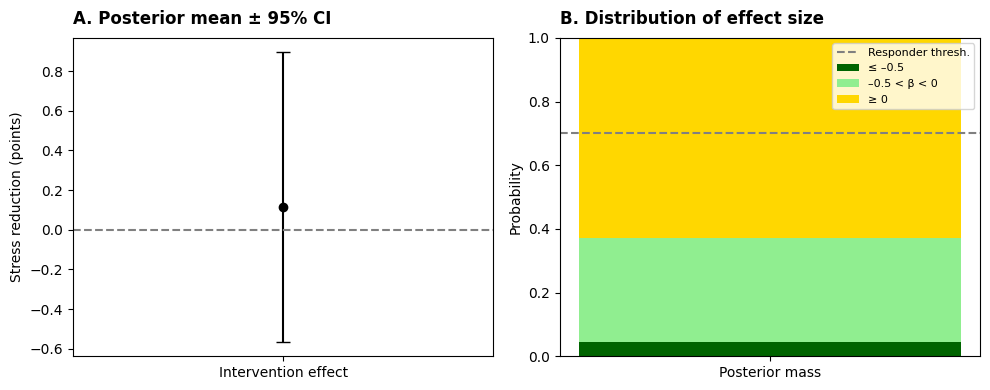


Model: Intervention + fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 226 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.081  0.330    -0.770      0.489      0.014    0.012     521.0   
rho       0.671  0.237     0.201      1.000      0.014    0.007     254.0   
sigma     0.726  0.103     0.550      0.946      0.004    0.004     569.0   
beta_f1   0.686  0.177     0.346      1.019      0.011    0.006     271.0   

          ess_tail  r_hat  
beta_int     569.0   1.01  
rho          356.0   1.00  
sigma        527.0   1.00  
beta_f1      432.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 11.00%
P(beta_int ≤ –0.5) = 11.00%
P(–0.5 < beta_int < 0) = 47.70%
P(beta_int ≥ 0) = 41.30%


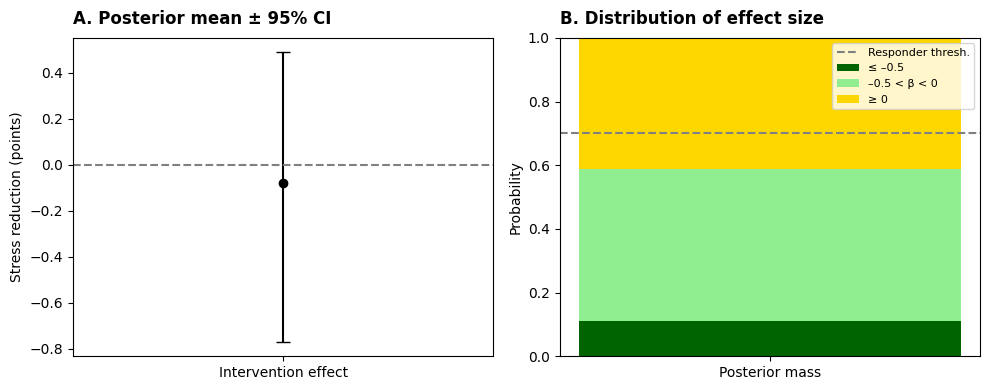


Model: Intervention + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 233 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.095  0.383    -0.649      0.821      0.022    0.019     333.0   
rho       0.575  0.279     0.101      0.998      0.022    0.008     146.0   
sigma     0.845  0.125     0.600      1.086      0.007    0.006     373.0   
beta_f2   0.668  0.260     0.167      1.157      0.022    0.015     156.0   

          ess_tail  r_hat  
beta_int     326.0   1.00  
rho          228.0   1.00  
sigma        400.0   1.01  
beta_f2      283.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 5.50%
P(beta_int ≤ –0.5) = 5.50%
P(–0.5 < beta_int < 0) = 33.60%
P(beta_int ≥ 0) = 60.90%


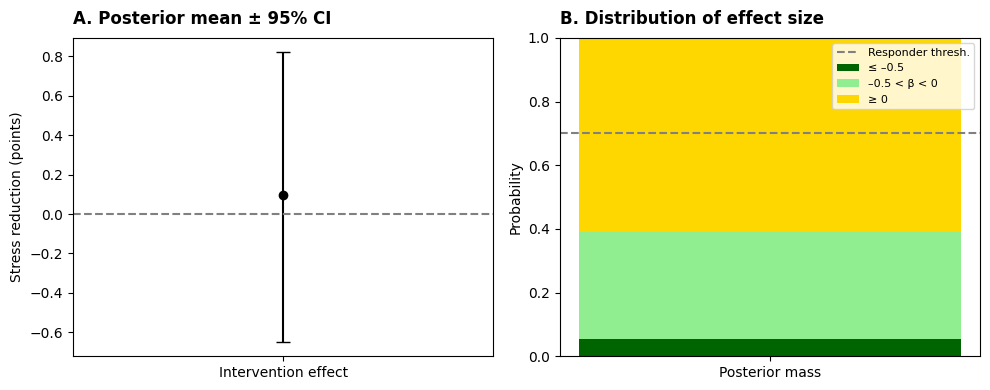


Model: Intervention + fac1 + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 307 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.067  0.362    -0.772      0.593      0.015    0.014     600.0   
rho       0.514  0.255     0.072      0.980      0.016    0.006     261.0   
sigma     0.718  0.104     0.551      0.927      0.004    0.004     614.0   
beta_f1   0.581  0.172     0.218      0.907      0.008    0.006     524.0   
beta_f2   0.250  0.205    -0.154      0.651      0.011    0.007     357.0   

          ess_tail  r_hat  
beta_int     487.0   1.00  
rho          364.0   1.00  
sigma        646.0   1.00  
beta_f1      530.0   1.00  
beta_f2      525.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 11.10%
P(beta_int ≤ –0.5) = 11.10%
P(–0.5 < beta_int < 0) = 46.60%
P(beta_int ≥ 0) = 42.30%


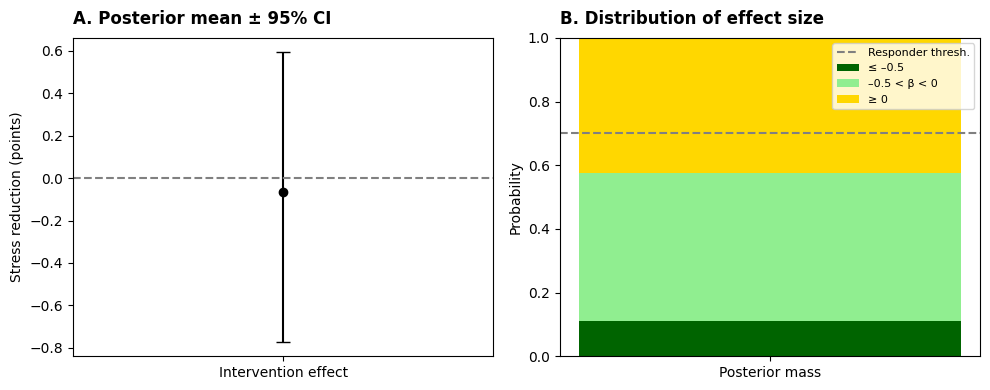

In [30]:
def run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Creating Literary Works!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    mad = np.median(np.abs(y - np.median(y)))
    scale = max(mad, 2.0)

    with pm.Model() as model:
        beta0    = pm.StudentT('beta0',    nu=3, mu=0, sigma=scale)
        beta_int = pm.StudentT('beta_int', nu=3, mu=0, sigma=scale)
        if include_fac1:
            beta_f1 = pm.StudentT('beta_f1', nu=3, mu=0, sigma=scale)
        if include_fac2:
            beta_f2 = pm.StudentT('beta_f2', nu=3, mu=0, sigma=scale)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfStudentT('sigma', nu=3, sigma=scale)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Only intervention")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False)

print("\nModel: Intervention + fac1")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=False)

print("\nModel: Intervention + fac2")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=True)

print("\nModel: Intervention + fac1 + fac2")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Regression with Consecutive‐Day Adjustment

Only intervention:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 444 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.647  0.503    -0.387      1.620      0.016    0.017     985.0   
rho       0.839  0.117     0.615      1.000      0.003    0.003     898.0   
sigma     1.219  0.159     0.935      1.529      0.007    0.005     504.0   

          ess_tail  r_hat  
beta_int     723.0   1.00  
rho          677.0   1.00  
sigma        627.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 1.60%
P(beta_int ≤ –0.5) = 1.60%
P(–0.5 < beta_int < 0) = 7.80%
P(beta_int ≥ 0) = 90.60%


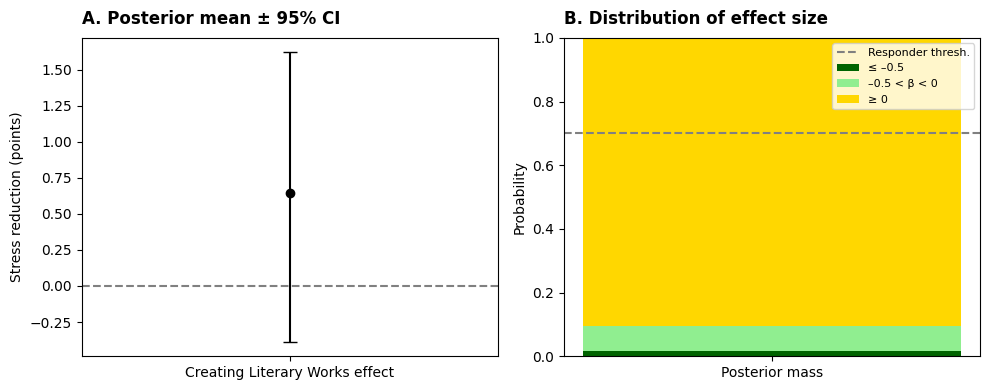


Intervention + fac1:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 528 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.010  0.323    -0.707      0.562      0.011    0.010     934.0   
rho       0.541  0.200     0.168      0.910      0.013    0.007     288.0   
sigma     0.728  0.099     0.547      0.912      0.005    0.003     401.0   
beta_f1   0.808  0.109     0.605      1.023      0.011    0.004     100.0   

          ess_tail  r_hat  
beta_int     704.0   1.00  
rho          457.0   1.01  
sigma        744.0   1.00  
beta_f1      286.0   1.02  
P(intervention reduces stress by ≥ 0.5 points) = 6.30%
P(beta_int ≤ –0.5) = 6.30%
P(–0.5 < beta_int < 0) = 43.70%
P(beta_int ≥ 0) = 50.00%


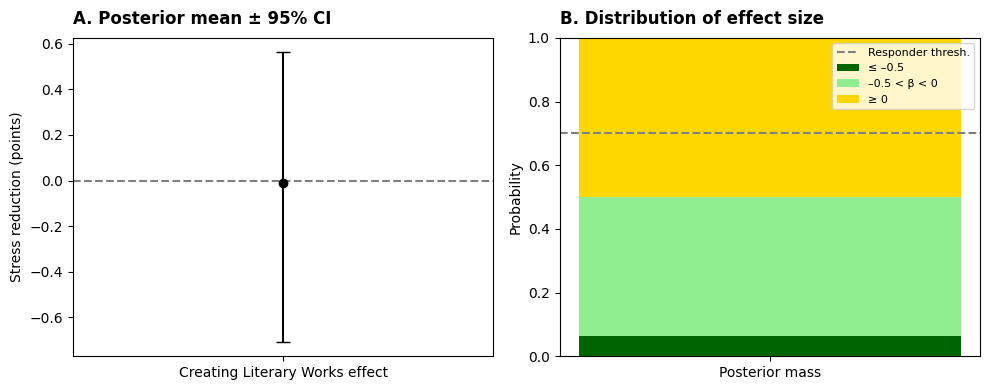


Intervention + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 548 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.122  0.346    -0.585      0.791      0.013    0.010     696.0   
rho       0.398  0.260    -0.134      0.838      0.023    0.008     125.0   
sigma     0.845  0.109     0.636      1.041      0.006    0.004     319.0   
beta_f2   0.830  0.150     0.537      1.125      0.017    0.011      79.0   

          ess_tail  r_hat  
beta_int     707.0   1.00  
rho          270.0   1.03  
sigma        477.0   1.00  
beta_f2      148.0   1.03  
P(intervention reduces stress by ≥ 0.5 points) = 4.10%
P(beta_int ≤ –0.5) = 4.10%
P(–0.5 < beta_int < 0) = 31.10%
P(beta_int ≥ 0) = 64.80%


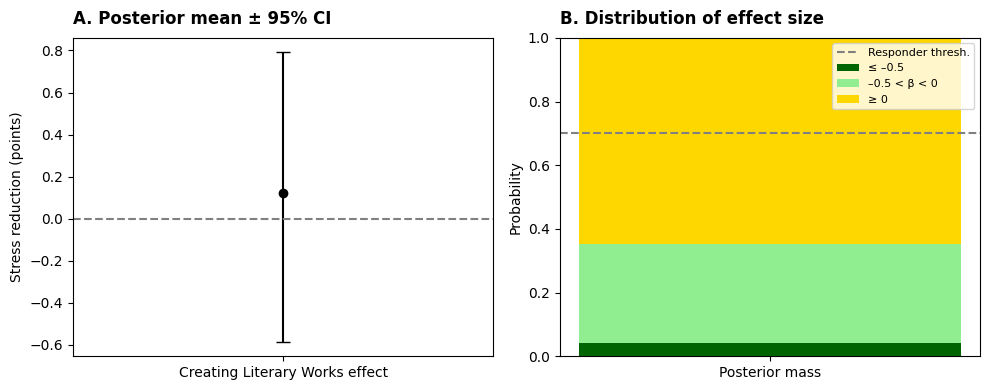


Intervention + fac1 + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 893 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.031  0.288    -0.627      0.540      0.008    0.011    1447.0   
rho       0.409  0.237    -0.025      0.893      0.020    0.009     141.0   
sigma     0.698  0.098     0.528      0.904      0.005    0.003     345.0   
beta_f1   0.612  0.174     0.280      0.950      0.007    0.006     650.0   
beta_f2   0.299  0.185    -0.085      0.620      0.010    0.006     383.0   

          ess_tail  r_hat  
beta_int     658.0   1.00  
rho          199.0   1.02  
sigma        617.0   1.00  
beta_f1      610.0   1.00  
beta_f2      772.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 6.20%
P(beta_int ≤ –0.5) = 6.20%
P(–0.5 < beta_int < 0) = 46.70%
P(beta_int ≥ 0) = 47.10%


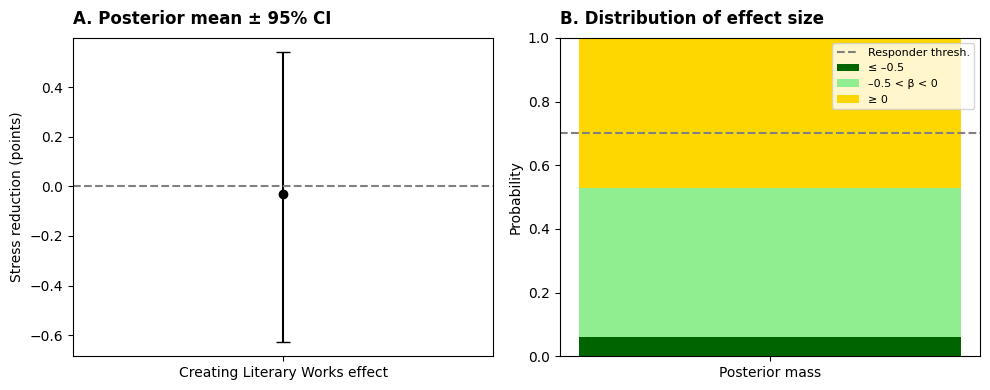

(Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
 beta_int -0.031  0.288    -0.627      0.540      0.008    0.011    1447.0   
 rho       0.409  0.237    -0.025      0.893      0.020    0.009     141.0   
 sigma     0.698  0.098     0.528      0.904      0.005    0.003     345.0   
 beta_f1   0.612  0.174     0.280      0.950      0.007    0.006     650.0   
 beta_f2   0.299  0.185    -0.085      0.620      0.010    0.006     383.0   
 
           ess_tail  r_hat  
 beta_int     658.0   1.00  
 rho          199.0   1.02  
 sigma        617.0   1.00  
 beta_f1      610.0   1.00  
 beta_f2      772.0   1.01  )

In [31]:
def run_ar1_model(df_mea, use_fac1=False, use_fac2=False):
    days_full = pd.DataFrame({'current_day_of_study': np.arange(0, 64)})

    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome'][
        ['current_day_of_study',
         'survey1_question1_response',   
         'current_intervention_name']
    ]
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators'][
        ['current_day_of_study',
         'survey2_question1_response',   
         'survey2_question2_response']   
    ]

    data = (
        days_full
        .merge(outcome_data,  on='current_day_of_study', how='left')
        .merge(mediator_data, on='current_day_of_study', how='left')
        .sort_values('current_day_of_study')
        .reset_index(drop=True)
    )

    days   = data['current_day_of_study'].values
    y      = data['survey1_question1_response'].values.astype(float)  
    n      = len(y)  

    interv = (data['current_intervention_name'] == "Creating Literary Works!").astype(float).fillna(0).values

    if use_fac1:
        fac1 = data['survey2_question1_response'].values.astype(float)
        fac1 = np.nan_to_num(fac1, nan=0.0)
    else:
        fac1 = np.zeros_like(days, dtype=float)

    if use_fac2:
        fac2 = data['survey2_question2_response'].values.astype(float)
        fac2 = np.nan_to_num(fac2, nan=0.0)
    else:
        fac2 = np.zeros_like(days, dtype=float)

    obs_mask = ~np.isnan(y)
    consec   = np.zeros(n, dtype=float)
    consec[1:] = (obs_mask[1:] & obs_mask[:-1]).astype(float)

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if use_fac1:
            beta_f1  = pm.Normal('beta_f1',  mu=0, sigma=10)
        if use_fac2:
            beta_f2  = pm.Normal('beta_f2',  mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if use_fac1:
            mu = mu + beta_f1 * fac1
        if use_fac2:
            mu = mu + beta_f2 * fac2

        y_tt      = pt.constant(y)            
        mu_tt     = mu
        consec_tt = pt.constant(consec)

        def ar1_step(y_prev, mu_prev, mu_curr, consec_prev, rho):
            ar_term = pt.switch(pt.eq(consec_prev, 1.0), rho * (y_prev - mu_prev), 0.0)
            return mu_curr + ar_term

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu_tt[:-1], mu_tt[1:], consec_tt[:-1]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu_tt[0]], y_pred_scan], axis=0)

        y_obs_masked = np.ma.masked_invalid(y)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_obs_masked)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if use_fac1:
        var_names.append('beta_f1')
    if use_fac2:
        var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4),
                             gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Creating Literary Works effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left',
                 pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold',       label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left',
                 pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

    return trace, summary

print("Only intervention:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=False)

print("\nIntervention + fac1:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=False)

print("\nIntervention + fac2:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=True)

print("\nIntervention + fac1 + fac2:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=True)


#### Bayesian AR(1) Model of Daily Stress Response to Creating Literary Works and Mediators - Mean Imputation

In [32]:
imputed_data_o = df_mea[df_mea['measurement_name'] == 'Outcome'].copy()
imputed_data_o['current_day_of_study'] = imputed_data_o['current_day_of_study'].astype(int)

imputed_data_m = df_mea[df_mea['measurement_name'] == 'Mediators'].copy()
imputed_data_m['current_day_of_study'] = imputed_data_m['current_day_of_study'].astype(int)

days = pd.DataFrame({'current_day_of_study': range(0, 32)})

imputed_complete_o = days.merge(
    imputed_data_o, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)

imputed_complete_m = days.merge(
    imputed_data_m, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_m['measurement_name'].fillna('Mediators', inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_21784\1570007407.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_21784\1570007407.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [33]:
df_o = imputed_complete_o.copy()
df_m = imputed_complete_m.copy()
pattern = (
    ['A'] * 4 +
    ['B'] * 8 +
    ['A'] * 4 +
    ['B'] * 4 +
    ['A'] * 8 +
    ['B'] * 4
)
txt = {
    'A': "Creating Literary Works!",
    'B': "Not Creating Literary Works!"
}

df_unique_o = (
    df_o
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()                                   
)

df_fill_o = (
    df_unique_o
    .reindex(range(0, 32))                     
    .reset_index()                             
)

mask_o = df_fill_o['current_intervention_name'].isna()
df_fill_o.loc[mask_o, 'current_intervention_name'] = (
    df_fill_o.loc[mask_o, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)

df_unique_m = (
    df_m
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()                                  
)

df_fill_m = (
    df_unique_m
    .reindex(range(0, 32))                    
    .reset_index()                             
)

mask_m = df_fill_m['current_intervention_name'].isna()
df_fill_m.loc[mask_m, 'current_intervention_name'] = (
    df_fill_m.loc[mask_m, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)

In [34]:
df_mean_imp_o = df_fill_o.copy()
df_mean_imp_m = df_fill_m.copy()
df_mean_imp_o['survey1_question1_response'] = (
    df_mean_imp_o
    .groupby('current_intervention_name')['survey1_question1_response']
    .transform(lambda grp: grp.fillna(grp.mean()))
)

cols_to_impute = [
    'survey2_question1_response',
    'survey2_question2_response'
]

for col in cols_to_impute:
    df_mean_imp_m[col] = (
        df_mean_imp_m
        .groupby('current_intervention_name')[col]
        .transform(lambda grp: grp.fillna(grp.mean()))
    )

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 122 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.061  0.358    -0.644      0.774      0.014    0.012     674.0   
rho       0.969  0.032     0.909      1.000      0.001    0.003     523.0   
sigma     0.861  0.104     0.681      1.076      0.004    0.003     862.0   

          ess_tail  r_hat  
beta_int     612.0   1.01  
rho          389.0   1.00  
sigma        828.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 5.20%
P(beta_int ≤ –0.5) = 5.20%
P(–0.5 < beta_int < 0) = 38.60%
P(beta_int ≥ 0) = 56.20%


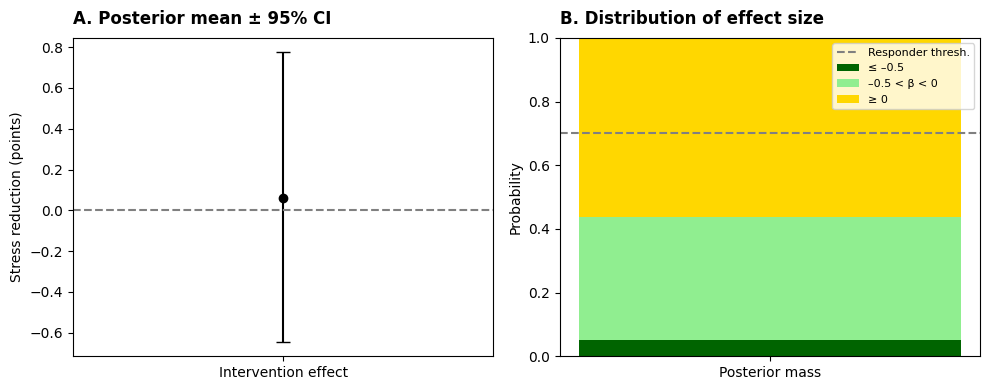

Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 236 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.108  0.286    -0.670      0.428      0.012    0.010     616.0   
rho       0.478  0.313    -0.041      0.998      0.027    0.010     125.0   
sigma     0.685  0.096     0.518      0.875      0.004    0.004     633.0   
beta_f1   0.770  0.185     0.400      1.098      0.017    0.010     135.0   

          ess_tail  r_hat  
beta_int     528.0   1.00  
rho           54.0   1.01  
sigma        565.0   1.00  
beta_f1      271.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 9.80%
P(beta_int ≤ –0.5) = 9.80%
P(–0.5 < beta_int < 0) = 55.60%
P(beta_int ≥ 0) = 34.60%


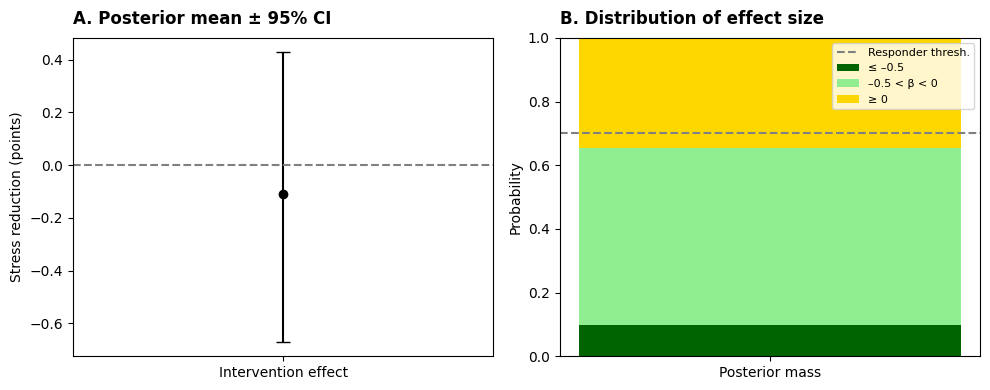

Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 318 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.069  0.357    -0.638      0.738      0.016    0.012     514.0   
rho       0.527  0.309     0.012      0.999      0.023    0.009     176.0   
sigma     0.842  0.112     0.644      1.045      0.005    0.004     460.0   
beta_f2   0.648  0.265     0.091      1.084      0.022    0.013     160.0   

          ess_tail  r_hat  
beta_int     533.0   1.00  
rho          357.0   1.00  
sigma        446.0   1.00  
beta_f2      296.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 6.10%
P(beta_int ≤ –0.5) = 6.10%
P(–0.5 < beta_int < 0) = 35.00%
P(beta_int ≥ 0) = 58.90%


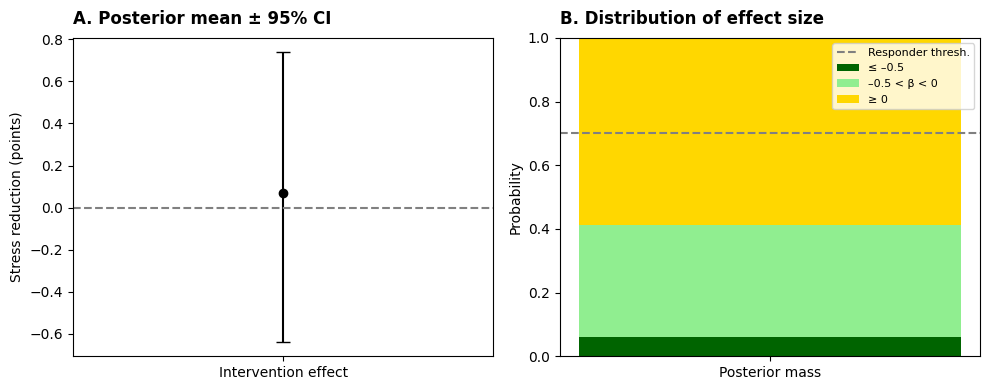

Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 391 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.079  0.286    -0.654      0.508      0.010    0.012     762.0   
rho       0.376  0.280    -0.050      0.994      0.019    0.012     234.0   
sigma     0.673  0.093     0.499      0.857      0.005    0.004     423.0   
beta_f1   0.623  0.166     0.321      0.943      0.009    0.005     359.0   
beta_f2   0.244  0.188    -0.121      0.600      0.011    0.007     316.0   

          ess_tail  r_hat  
beta_int     496.0   1.00  
rho          168.0   1.01  
sigma        515.0   1.00  
beta_f1      514.0   1.00  
beta_f2      508.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 7.00%
P(beta_int ≤ –0.5) = 7.00%
P(–0.5 < beta_int < 0) = 55.50%
P(beta_int ≥ 0) = 37.50%


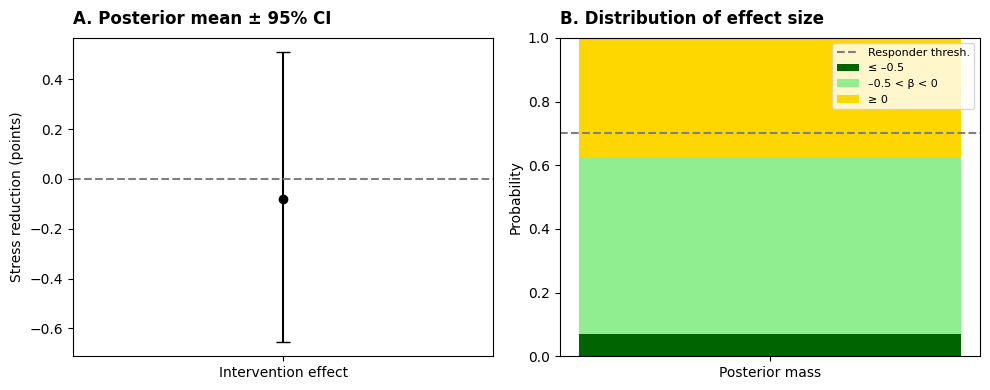

In [35]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mean_imp_o.copy()
    mediator_data = df_mean_imp_m.copy()

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Creating Literary Works!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Model of Daily Stress Response to Creating Literary Works and Mediators - Latent Missing Method

In [36]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    all_days = pd.DataFrame({'current_day_of_study': np.arange(0, 32)})
    outcome_data = pd.merge(all_days, outcome_data[merge_cols], on='current_day_of_study', how='left')
    if mediator_cols:
        mediator_data = pd.merge(all_days,
                                  mediator_data[['current_day_of_study'] + mediator_cols],
                                  on='current_day_of_study', how='left')
    else:
        mediator_data = all_days.copy()

    data = (pd.merge(outcome_data, mediator_data, on='current_day_of_study', how='left')
              .sort_values('current_day_of_study')
              .reset_index(drop=True))

    y_obs_raw = data['survey1_question1_response'].values
    y_obs = y_obs_raw.astype(float)
    interv = (data['current_intervention_name'] == "Creating Literary Works!").astype(float).fillna(0.0)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None
    n = len(y_obs)

    nan_idx = np.isnan(y_obs)
    obs_idx = ~nan_idx
    missing_idx = np.where(nan_idx)[0].tolist()

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho   = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * pt.as_tensor_variable(np.nan_to_num(fac1, nan=0.0))
        if include_fac2:
            mu = mu + beta_f2 * pt.as_tensor_variable(np.nan_to_num(fac2, nan=0.0))

        y_latent = pm.Normal('y_latent', mu=0, sigma=10, shape=len(missing_idx))

        y_filled = pt.zeros(n)
        y_filled = pt.set_subtensor(y_filled[missing_idx], y_latent)
        y_filled = pt.set_subtensor(y_filled[obs_idx], y_obs[obs_idx])

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_filled[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1
        )
        y_pred = pt.concatenate([mu[:1], y_pred_scan], axis=0)

        pm.Normal('y_obs',
                  mu=y_pred[obs_idx],
                  sigma=sigma,
                  observed=y_obs[obs_idx])

        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9,
                          return_inferencedata=True)

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1: var_names.append('beta_f1')
    if include_fac2: var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 161 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.045  0.335    -0.583      0.712      0.014    0.010     599.0   
rho       0.969  0.029     0.917      1.000      0.001    0.002     555.0   
sigma     0.811  0.124     0.607      1.061      0.005    0.004     754.0   

          ess_tail  r_hat  
beta_int     680.0    1.0  
rho          558.0    1.0  
sigma        688.0    1.0  
P(beta_int ≤ –0.5) = 5.50%
P(–0.5 < beta_int < 0) = 38.90%
P(beta_int ≥ 0) = 55.60%
Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 447 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.063  0.316    -0.633      0.634      0.014    0.012     539.0   
rho       0.544  0.353    -0.010      1.000      0.040    0.008     101.0   
sigma     0.727  0.101     0.535      0.934      0.005    0.004     445.0   
beta_f1   0.704  0.243     0.257      1.096      0.025    0.007     102.0   

          ess_tail  r_hat  
beta_int     517.0   1.00  
rho          438.0   1.02  
sigma        485.0   1.00  
beta_f1      434.0   1.02  
P(beta_int ≤ –0.5) = 8.10%
P(–0.5 < beta_int < 0) = 50.10%
P(beta_int ≥ 0) = 41.80%
Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 627 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.095  0.342    -0.757      0.632      0.020    0.013     303.0   
rho       0.366  0.390    -0.091      0.999      0.063    0.016      44.0   
sigma     0.864  0.122     0.637      1.106      0.008    0.007     224.0   
beta_f2   0.733  0.341     0.015      1.160      0.051    0.022      52.0   

          ess_tail  r_hat  
beta_int     297.0   1.00  
rho          243.0   1.03  
sigma        428.0   1.00  
beta_f2      193.0   1.03  
P(beta_int ≤ –0.5) = 5.50%
P(–0.5 < beta_int < 0) = 29.90%
P(beta_int ≥ 0) = 64.60%
Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 697 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.012  0.282    -0.547      0.586      0.011    0.010     690.0   
rho       0.245  0.303    -0.066      0.996      0.047    0.037      59.0   
sigma     0.715  0.106     0.522      0.917      0.004    0.004     640.0   
beta_f1   0.601  0.191     0.231      0.981      0.011    0.007     313.0   
beta_f2   0.316  0.226    -0.160      0.743      0.019    0.011     148.0   

          ess_tail  r_hat  
beta_int     587.0   1.01  
rho           60.0   1.02  
sigma        462.0   1.00  
beta_f1      505.0   1.01  
beta_f2      187.0   1.02  
P(beta_int ≤ –0.5) = 4.30%
P(–0.5 < beta_int < 0) = 45.90%
P(beta_int ≥ 0) = 49.80%
